# 強化学習勉強会 
---------------------------------------
<div style="text-align: right;">
     RDC.Lab
    <br>
     B4 Matsumoto Koki 
    <br>
    2020/08/24 Mon.  
</div>

## はじめに
---------------------------------------
+ これはRDC.Lab(林原研究室)のB3に向けた強化学習の勉強会の資料です。
+ ライントレースカーの制御を強化学習で実装してみたもの使って説明していきます。
+ インストールが必要なライブラリや環境は以下の通りです。
    - **numpy**
    - **matplotlib**
    - **python3.x**
    - **jupyter notebook**
+ 可能な限りコメントを入れてコードの解説をしていますが、pythonに慣れてない方も多いと思うのでわからないところは気軽に質問に来てください！
> 質問はslackのDMかtimes_matsumotoにどうぞ！

# コード解説
---------------------------------------
## 1. import 部分

In [1]:
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
from matplotlib import animation
import csv
from collections import deque
import IPython.display

## 2. field定義
---------------------------------------
- 知能ロボコンのフィールドを参考に作成  
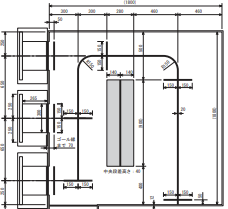

In [2]:
# センサの判定部分
n_line = []
n_line.append(lambda x: -10<=x[0]<=10 and -10<=x[1]<=1150)
n_line.append(lambda x: x[0]<=150 and 1150<=x[1] and 140<=np.linalg.norm(np.array(x)-np.array([150,1150]))<=160)
n_line.append(lambda x: 150<=x[0]<=300 and 1290<=x[1]<=1310)
n_line.append(lambda x: 300<=x[0]<=890 and 1290<=x[1]<=1310)
n_line.append(lambda x: 890<=x[0] and 1150<=x[1] and 140<=np.linalg.norm(np.array(x)-np.array([890,1150]))<=160)
n_line.append(lambda x: 1030<=x[0]<=1050 and 1000<=x[1]<=1150)
n_line.append(lambda x: 1030<=x[0]<=1050 and 900<=x[1]<=1000)
n_line.append(lambda x: 1030<=x[0]<=1050 and 800<=x[1]<=900)

In [3]:
# 可視化のためにプロット
nplot_x1 = [10]
nplot_y1 = [0]
nplot_x2 = [-10]
nplot_y2 = [0]

for th in (np.linspace(0,pi/2,45)):
    nplot_x1.append(150-140*np.cos(th))
    nplot_y1.append(1150+140*np.sin(th))
    nplot_x2.append(150-160*np.cos(th)) 
    nplot_y2.append(1150+160*np.sin(th)) 

for th in (np.linspace(0,pi/2,45)):
    nplot_x1.append(890+140*np.sin(th))
    nplot_y1.append(1150+140*np.cos(th))
    nplot_x2.append(890+160*np.sin(th)) 
    nplot_y2.append(1150+160*np.cos(th)) 
    
nplot_x1.append(1030)
nplot_y1.append(900)
nplot_x2.append(1050)
nplot_y2.append(900)

## 3. フィールドを描画してみる

In [4]:
#　結果部分でも使うので関数化しておく
def plot_field_line(plt):
    plt.plot(nplot_x1,nplot_y1,color="black")
    plt.plot(nplot_x2,nplot_y2,color="black")

/Users/koki/pyfiles/env/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


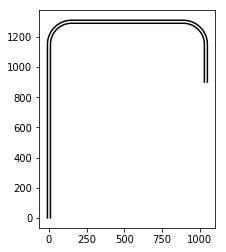

In [5]:
plot_field_line(plt)
plt.axes().set_aspect('equal')
plt.show()

## 4. ライントレースカー の定義
---------------------------------------
- 最高速度 10mm/sec
- トレッド 200mm
- ロボットの中心から150mm前方に4つ設置

In [6]:
class line_trace_car(object):
    sensors = np.array([[150,22.5],[150,7.5],[150,-7.5],[150,-22.5]])   # センサの位置を定義
    tread = 200                                                                                                     #  トレッドの定義
    car_order = [0,10]                                                                                         #  最低/最高速度の定義
    init_pos = np.array([[-10,10],[-10,10],[80*pi/180,100*pi/180]])      # 　初期位置候補
    action_space = 9                                                                                            #  行動空間(加速、減速、何もしない)^(右、左)の9種類
        
    def __init__(self,lines):
        self.lines = lines
        
        # 初期位置決定 センサのどこかしらが反応してるところから開始するようにする
        while True:
            self.pos_x = np.random.uniform(self.init_pos[0,0],self.init_pos[0,1])
            self.pos_y = np.random.uniform(self.init_pos[1,0],self.init_pos[1,1]) - 150
            self.pos_a = np.random.uniform(self.init_pos[2,0],self.init_pos[2,1])
            if any(self.get_sense()):
                break
                
        # 角速度の初期化
        self.mtrL = self.car_order[0]
        self.mtrR = self.car_order[0]
        
        # ログの初期化
        self.car_pos = [[],[]]
        self.sensor_pos = []
        for _ in range(len(self.sensors)):
            self.sensor_pos.append([[],[]])
            
    def get_sense(self):   # センサの値を取得できる関数
        sense = []
        angs = np.array([[np.cos(self.pos_a),-np.sin(self.pos_a)],[np.sin(self.pos_a),np.cos(self.pos_a)]])   #回転行列
        
        #センサを座標変換 ＆ センサの01を判断
        for i in range(len(self.sensors)):
            sensor_val = 0
            sensor_p = np.array([sum(self.sensors[i] * angs[0]) + self.pos_x,sum(self.sensors[i]  * angs[1]) +  self.pos_y])
            for j ,line in enumerate(self.lines):
                if line(sensor_p):
                    sensor_val = j+1
                    break
            sense.append(sensor_val)
        return sense
    
    def step(self,action=9):
        #　9種類の行動に合わせてモーターの制御
        mL = np.clip(self.mtrL + action//3 -1, self.car_order[0],self.car_order[1])           
        mR = np.clip(self.mtrR + action%3 -1, self.car_order[0],self.car_order[1])
        
        #　±5%の範囲でノイズを発生させる
        act_mL =np.random.uniform(0.45,0.55) * (self.mtrL + mL)
        act_mR =np.random.uniform(0.45,0.55) * (self.mtrR + mR)
        
        # 座標, 姿勢の計算
        mid_angle =  self.pos_a + (act_mR-act_mL) / (4 * self.tread) 
        self.pos_x += np.cos(mid_angle) * (act_mL+act_mR)/2
        self.pos_y += np.sin(mid_angle) * (act_mL+act_mR)/2
        self.pos_a += (act_mR-act_mL)/(2 * self.tread)
        real = (mL - self.mtrL + 1) * 3 + (mR - self.mtrR + 1)
        
        # モーター速度の更新
        self.mtrL = mL
        self.mtrR = mR
        
        return ([act_mL,act_mR],real)
    
    def checck_done(self,sense):     # 終了判定
        sense = np.array(sense)
        done = 0
        if not any(sense):                      # センサが一個も反応しなかったら終了
            done = -1
        elif min(sense[sense.nonzero()]) == len(self.lines):   # ゴールに達しても終了
            done = 1
        return done

    
    # 座標の記録
    def plot_state(self):
        self.car_pos[0].append(self.pos_x)
        self.car_pos[1].append(self.pos_y)
        angs = np.array([[np.cos(self.pos_a),-np.sin(self.pos_a)],[np.sin(self.pos_a),np.cos(self.pos_a)]])
        for i in range(len(self.sensors)):
            sensor_p = np.array([sum(self.sensors[i] * angs[0]) + self.pos_x,sum(self.sensors[i]  * angs[1]) +  self.pos_y])
            self.sensor_pos[i][0].append(sensor_p[0])
            self.sensor_pos[i][1].append(sensor_p[1])

    # 軌跡の可視化(今回は使ってない)
    def path_plot(self,plt,data):
        plt.plot(self.car_pos[0][-1],self.car_pos[1][-1],label="car_pos")
        for i in range(len(self.sensors)):
            plt.plot(self.sensor_pos[i][0][-1],self.sensor_pos[i][1][-1],label="sensor"+str(i+1))

## 5. 学習部分

In [7]:
# 状態空間の取得
def get_state(car,s_state,v_state):
    state = [i != 0 for i in s_state]
    state.extend([car.mtrL,car.mtrR])
    # 2進数表現を10進数表現に変換するイメージで現在の状態を表現
    return sum(np.array(state) * (np.array([1,2,4,8,16,(line_trace_car.car_order[1]-line_trace_car.car_order[0]+1)*16])))

In [8]:
#　 Q_tableから行動を決定する
def decide_action(next_state,episode,q_table):
    # ε-グリーディ法を採用
    first_probability = 0.75
    epsilon = first_probability * (1/(episode+1))
    if epsilon <= np.random.uniform(0,1):
        next_action = np.argmax(q_table[next_state])            #Q値の一番大きい行動を選択
    else:
        prob = sum(q_table[next_state]+100)                         #マイナスにならないようにマージン(もっといい方法あるかも)
        w = (q_table[next_state]+100) / prob
        next_action = np.random.choice(range(9) ,p=w)         # 確率でランダムな行動を選択
    return next_action

In [9]:
#  Q-tableを更新する
def update_Qtable(q_table,state,action,reward,next_state):
    gamma = 0.9
    alpha = 0.8
    next_max_q = max(q_table[next_state])
    q_table[state,action] = (1 - alpha) * q_table[state,action] + alpha * (reward + gamma * next_max_q)    #　Q学習の式から
    return q_table

In [10]:
# 　報酬関数の設定　  （自由に変えてください！）
def update_reward(v_state,s_state,done,level):
        reward = 0
        if sum(v_state)/2 <= 1:
            reward = -1 
        if s_state[0] or s_state[3]:
            reward += -0.1
        elif not done:
            reward += level 
        elif done and level == 8:
            reward += 500
        else:
            reward = -10
        return reward

In [11]:
# 実行部分
def run():
    # 各種パラメータ群
    legend_flag = False 
    result = False
    learining_is_done = False
    max_episode = 10000                                             #　最大エピソード数
    step_by_episode = 1500                                        # 1エピソード毎の最大step数
    goal_ave = 8.0                                                          # 学習が終了する値
    review_num = 10                                                      # 評価する値の直近の数
    reward_of_episode = 0                                            # 報酬の初期化
    goal_times = 0                                                          # ゴールした回数
    reward_ave = np.full(review_num,0)                     # 直近10回の報酬値を格納  
    # Q-tableの初期化
    q_table = np.random.uniform(low=-1,high=1,\
                                                        size=(2**4 * (line_trace_car.car_order[1]-line_trace_car.car_order[0]+1) ** 2 , \
                                                        line_trace_car.action_space))
    transition_data = [] 
    x_axis = []

    np.random.seed(0)
    
    for episode in range(max_episode):
        if result: break
        level = 0
        reward_of_episode = 0
        reward = 0
        car=line_trace_car(n_line)                                  # ライントレースカーのインスタンスを作成
        s_state = car.get_sense()                                   # センサ値を取得 
        v_state = None 
        state  = get_state(car,s_state,v_state) 
        action = np.argmax(q_table[state])                  #Q-tableからアクションを選択


        for i in range(step_by_episode):
            v_state = car.step(action)[0]
            s_state = car.get_sense()
            done = car.checck_done(car.get_sense())                                           # 終了判定
            reward = update_reward(v_state,s_state,done,level)                        # 報酬を取得
            reward_of_episode += reward
            level = max(max(s_state), level)                                                            # 現在の位置
            
            next_state = get_state(car,s_state,v_state)                                      # 状態空間を取得
            q_table = update_Qtable(q_table,state,action,reward,next_state) #  Q-tabelの更新
            action = decide_action(next_state,episode,q_table)
            state = next_state
            
            # 可視化用
            if learining_is_done:
                car.plot_state()
            
            if done:
                if level == 8:
                    goal_times+=1
                legend_flag = False
                reward_ave = np.hstack((reward_ave[1:],level))               # 最終到達地を格納
                if episode%100 == 99:
                    # アウトプット用　jupyterだと幅の確保ができなくてちょっと汚いかも
                    print("episode %5d, reward %6d, step %5d, level %d" %(episode+1,reward_of_episode,i+1,level))  
                transition_data.append(reward_ave.mean())
                x_axis.append(episode)
                if learining_is_done == 1 :
                    fig, ax = plt.subplots(figsize=(5,8))
                    plot_field_line(ax)
                    ims = []
                    for i in range(len(car.car_pos[0])):
                            if i % 10!=0: continue
                            #p1 = ax.plot(car.car_pos[0][:i], car.car_pos[1][:i],color="blue",label="car pos",marker="o",markersize=0.0)
                            p2 = ax.plot(car.sensor_pos[0][0][:i], car.sensor_pos[0][1][:i],color="orange",label="sensor1",marker="o",markersize=1)
                            p3 = ax.plot(car.sensor_pos[1][0][:i], car.sensor_pos[1][1][:i],color="green",label="sensor2",marker="o",markersize=1)
                            p4 = ax.plot(car.sensor_pos[2][0][:i], car.sensor_pos[2][1][:i],color="red",label="sensor3",marker="o",markersize=1)
                            p5 = ax.plot(car.sensor_pos[3][0][:i], car.sensor_pos[3][1][:i],color="purple",label="sensor4",marker="o",markersize=1)
                            if i == 0 : ax.legend()
                            ims.append(p2+p3+p4+p5)
                    ani = animation.ArtistAnimation(fig, ims)
                    plt.show()
                    result = True
                break

        # 簡単なlogの記録
        if (reward_ave.mean() >= goal_ave) or  episode+1 == max_episode:
            print("Episode %d train agent fin!" %(episode+1))
            print("goal_times: "+str(goal_times))
            with open('./csv/file.csv', 'wt') as f:
                writer = csv.writer(f)
                writer.writerows(q_table)
            print("saved")
            with open('./csv/transition_data.csv', 'wt') as f:
                writer = csv.writer(f)
                data = np.c_[x_axis,transition_data]
                writer.writerows(data)
            learining_is_done = 1

## 6. 実行＆結果
---------------------------------------

episode   100, reward    304, step   333, level 2
episode   200, reward    304, step   316, level 2
episode   300, reward    295, step   329, level 2
episode   400, reward    120, step   162, level 1
episode   500, reward    170, step   264, level 2
episode   600, reward    832, step   815, level 2
episode   700, reward    724, step   724, level 2
episode   800, reward    543, step   588, level 2
episode   900, reward   1734, step   870, level 5
episode  1000, reward    554, step   570, level 2
episode  1100, reward    600, step   595, level 2
episode  1200, reward    590, step   577, level 2
episode  1300, reward    590, step   559, level 3
episode  1400, reward    655, step   611, level 2
episode  1500, reward    655, step   647, level 3
Episode 1520 train agent fin!
goal_times: 14
saved


<IPython.core.display.Javascript object>


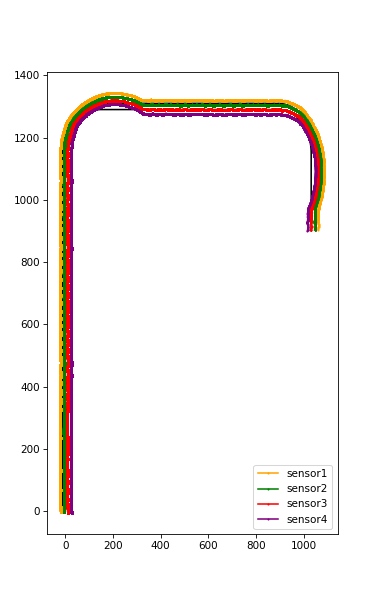

Episode 1521 train agent fin!
goal_times: 15
saved


In [12]:
%matplotlib nbagg
run()

## 7-1 成功と失敗の例
---------------------------------------
<table>
    <tr>
        <td><img src="faild.png"></td>
        <td><img src="success.png"></td>
    </tr>
</table>

## 7-2 アニメーション
---------------------------------------

In [13]:
IPython.display.YouTubeVideo('xj121Km8_tw')